In [1]:
#ID : 20200090 + 20200232
#
# S: 5

import numpy as np
import random
from keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train=X_train.astype('float64')
X_test=X_test.astype('float64')

train_mask = np.logical_or(y_train == 0, y_train == 1)
test_mask = np.logical_or(y_test == 0, y_test == 1)
X_train, y_train = X_train[train_mask], y_train[train_mask]
X_test, y_test = X_test[test_mask], y_test[test_mask]

shuffled_indices = np.random.permutation(len(X_train))
X_train = X_train[shuffled_indices]
y_train = y_train[shuffled_indices]

X_imgtrain=X_train
X_imgtest=X_test
"""
#scale
X_train = X_train/255 
X_test = X_test/255
"""
std=np.std(X_train, axis=0)
std=np.where(std==0,1,std)
X_train=(X_train - np.mean(X_train,axis=0))/std

std1=np.std(X_test, axis=0)
std1=np.where(std1==0,1,std1)
X_test=(X_test - np.mean(X_test,axis=0))/std1

X_train = np.reshape(X_train, (-1, 784))
X_test = np.reshape(X_test, (-1, 784))

print(X_train.shape)  
print(X_test.shape)   

(12665, 784)
(2115, 784)


Label: 1


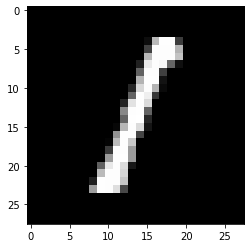

In [2]:
import matplotlib.pyplot as plt
image, label = X_imgtrain[0],y_train[0]
plt.imshow(image, cmap='gray')
print("Label:",label)

In [3]:
def train_val_split(X_train,y_train,split_ratio =0.8):
    np.random.seed(0)
    shuffle_indices = np.random.permutation(len(y_train))
    X_shuffled = X_train[shuffle_indices]
    y_shuffled = y_train[shuffle_indices]
    split_index = int(len(y_train) * split_ratio)
    # Split the data
    X_train = X_shuffled[:split_index]
    y_train = y_shuffled[:split_index]
    X_val = X_shuffled[split_index:]
    y_val = y_shuffled[split_index:]

    return X_train, X_val, y_train, y_val


X, val_X, y, val_y=train_val_split(X_train,y_train, 0.8)

In [4]:
def sigmoid(z):
    #return 1.0 / (1.0 + np.exp(-z)) 
    res=np.where((-z) > 0, 1.0 / (1.0 + np.exp(-z)), 1.0 / (1.0 + np.exp(-z+ 1e-15)))   
    return res
def pred(val_X,val_y,w,b):
    z=(val_X @ w)+b
    prediction = sigmoid(z)     
    prediction = [1 if elem > 0.5 else 0 for elem in prediction]         
    error=np.sum(prediction !=  val_y)  
    score=round(np.mean(prediction ==  val_y)*100,2)
    print("error",error)
    print("score",score)

In [5]:
def logisticRegression_L1(X, y,w,b, num_iter, lr, lambda_val):
    tolerance = 1e-8
    m, n = X.shape 

    for i in range(num_iter):
        z = X @ w
        yp = sigmoid(z)
        y = y.reshape((m, 1))
        cost = (1 / m) * (-(y.T @ np.log(yp)) - ((1 - y).T @ np.log(1 - yp))) + (lambda_val / m) * np.sum(np.abs(w))
        cost = cost.sum(axis=0)
        dw = (1 / m) * (X.T @ (yp - y)) + (lambda_val / m) * np.sign(w)
        w = w - (dw * lr)
        db = np.mean(yp - y) 
        b = b - (db * lr)
        if cost < tolerance:
            break

    return w,b

In [6]:
def logisticRegression_miniBatch(X, y,w,b, num_iter, lr, batch_size):
    tolerance = 1e-8
    m, n = X.shape
    num_batches = int(np.ceil(m / batch_size))
    for i in range(num_iter):
        cost = 0
        for j in range(num_batches):
            batch_start = j * batch_size
            batch_end = min(batch_start + batch_size, m)
            X_batch = X[batch_start:batch_end, :]
            y_batch = (y[batch_start:batch_end]).reshape(-1,1)
            z = X_batch @ w
            yp = sigmoid(z)
            cost += (1 / m) * (-(y_batch.T @ np.log(yp)) - ((1 - y_batch).T @ np.log(1 - yp)))
            dw = (1 / m) * (X_batch.T @ (yp - y_batch))
            w = w - (dw * lr)
            db = np.mean(yp - y_batch)
            b = b - (db * lr)
        if cost < tolerance:
            break
    return w,b

In [7]:
def logisticRegression_RMSprop(X, y,w,b, num_iter, lr, b1, epsilon= 1e-8):
    tolerance = 1e-8
    m, n = X.shape 
    vdw = np.zeros((n,1))
    vdb = 0
    t = 0
    
    for i in range(num_iter):
        t += 1
        z = X @ w
        yp = sigmoid(z) 
        y = y.reshape((m, 1))        
        cost= (1 / m) *( -(y.T @ np.log(yp)) - ((1 - y).T @ np.log(1 - yp)) ) 
        cost = cost.sum(axis=0)
        dw = (1 / m) * (X.T @ (yp - y))
        vdw = (b1 * vdw + (1 - b1) * np.square(dw))/ (1 - b1 ** t)  #unbiased
        w = w - (lr * dw / (np.sqrt(vdw) + epsilon))
        
        db = np.mean(yp - y)
        vdb = (b1 * vdb + (1 - b1) * np.square(db))/ (1 - b1 ** t)  #unbiased
        b = b - (lr * db / (np.sqrt(vdb) + epsilon))

        if cost < tolerance: break
        
    return w,b

In [8]:
def logisticRegression_Adam(X, y,w,b, num_iter, lr, b1, b2, epsilon= 1e-8):
    tolerance = 1e-8
    m, n = X.shape 
    vdw_m = np.zeros((n,1))      #momentum for w
    vdw_rms = np.zeros((n,1))    #RMSprop  for w

    vdb_m = 0                    #momentum for b
    vdb_rms = 0                  #RMSprop  for b
    t = 0
    
    for i in range(num_iter):
        t += 1
        z = (X @ w)+b
        yp = sigmoid(z)
        y = y.reshape((m, 1))        
        cost= (1 / m) *( -(y.T @ np.log(yp)) - ((1 - y).T @ np.log(1 - yp)) ) 
        cost = cost.sum(axis=0)
        dw = (1 / m) * (X.T @ (yp - y))
        vdw_m = (b1 * vdw_m + (1 - b1) * dw)/ (1 - b1 ** t)                     #momentum_unbiased       
        vdw_rms = (b2 * vdb_rms + (1 - b2) * np.square(dw))/ (1 - b2 ** t)      #RMSprop_unbiased
        w = w - (lr * vdw_m / (np.sqrt(vdw_rms) + epsilon))

        db = np.mean(yp - y)
        vdb_m = (b1 * vdb_m + (1 - b1) * db)/ (1 - b1 ** t)                     #momentum_unbiased  
        vdb_rms = (b2 * vdb_m + (1 - b2) * np.square(db))/ (1 - b2 ** t)        #RMSprop_unbiased
        b = b - (lr * vdb_m / (np.sqrt(vdb_rms) + epsilon))
        
        
        if cost < tolerance: break
        
    return w,b

In [16]:
random.seed(0)
w = np.random.uniform(size=(X.shape[1],1), low=-0.2, high=0.1)
b = 0

In [17]:
w1_L1,b1_L1 = logisticRegression_L1(X, y,w,b, num_iter=1000, lr=0.1, lambda_val=1)
w2_L1,b2_L1 = logisticRegression_L1(X, y,w,b, num_iter=1000, lr=0.1, lambda_val=0.1)
print("L1_reg with lambda_val=1")
pred(val_X,val_y,w1_L1,b1_L1)
print("L1_reg with lambda_val=0.1")
pred(val_X,val_y,w2_L1,b2_L1)

w1_miniBatch,b1_miniBatch = logisticRegression_miniBatch(X, y,w,b, num_iter=1000, lr=0.1, batch_size=5000)
w2_miniBatch,b2_miniBatch = logisticRegression_miniBatch(X, y,w,b, num_iter=1000, lr=0.1, batch_size=1000)
print("MiniBatch with batch_size=5000")
pred(val_X,val_y,w1_miniBatch,b1_miniBatch)
print("MiniBatch with batch_size=1000")
pred(val_X,val_y,w2_miniBatch,b2_miniBatch)

w_rms,b_rms = logisticRegression_RMSprop(X, y,w,b, num_iter=1000, lr=0.1, b1=0.99)
w_adam,b_adam = logisticRegression_Adam(X, y,w,b, num_iter=1000, lr=0.1, b1=0.9, b2=0.99)
print("RMSprop")
pred(val_X,val_y,w_rms,b_rms)
print("Adam")
pred(val_X,val_y,w_adam,b_adam)

L1_reg with lambda_val=1
error 4
score 99.84
L1_reg with lambda_val=0.1
error 4
score 99.84
MiniBatch with batch_size=5000
error 4
score 99.84
MiniBatch with batch_size=1000
error 8
score 99.68


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_5436/1850094203.py:13: RuntimeWarning: divide by zero encountered in log
  cost= (1 / m) *( -(y.T @ np.log(yp)) - ((1 - y).T @ np.log(1 - yp)) )
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_5436/1850094203.py:13: RuntimeWarning: invalid value encountered in matmul
  cost= (1 / m) *( -(y.T @ np.log(yp)) - ((1 - y).T @ np.log(1 - yp)) )
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_5436/1876696833.py:16: RuntimeWarning: divide by zero encountered in log
  cost= (1 / m) *( -(y.T @ np.log(yp)) - ((1 - y).T @ np.log(1 - yp)) )
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_5436/1876696833.py:16: RuntimeWarning: invalid value encountered in matmul
  cost= (1 / m) *( -(y.T @ np.log(yp)) - ((1 - y).T @ np.log(1 - yp)) )
C:\Users\Lenovo\AppData\Local\Temp/ipykernel_5436/950542085.py:3: RuntimeWarning: overflow encountered in exp
  res=np.where((-z) > 0, 1.0 / (1.0 + np.exp(-z)), 1.0 / (1.0 + np.exp(-z+ 1e-15)))


RMSprop
error 32
score 98.74
Adam
error 6
score 99.76


In [18]:
# test data
print("L1_reg with lambda_val=1")
pred(X_test,y_test,w1_L1,b1_L1)
print("L1_reg with lambda_val=0.1")
pred(X_test,y_test,w2_L1,b2_L1)

print("MiniBatch with batch_size=5000")
pred(X_test,y_test,w1_miniBatch,b1_miniBatch)
print("MiniBatch with batch_size=1000")
pred(X_test,y_test,w2_miniBatch,b2_miniBatch)

print("RMSprop")
pred(X_test,y_test,w_rms,b_rms)
print("Adam")
pred(X_test,y_test,w_adam,b_adam)

L1_reg with lambda_val=1
error 0
score 100.0
L1_reg with lambda_val=0.1
error 0
score 100.0
MiniBatch with batch_size=5000
error 1
score 99.95
MiniBatch with batch_size=1000
error 2
score 99.91
RMSprop
error 19
score 99.1
Adam
error 3
score 99.86


C:\Users\Lenovo\AppData\Local\Temp/ipykernel_5436/950542085.py:3: RuntimeWarning: overflow encountered in exp
  res=np.where((-z) > 0, 1.0 / (1.0 + np.exp(-z)), 1.0 / (1.0 + np.exp(-z+ 1e-15)))


In [ ]:
from sklearn.linear_model import SGDClassifier
clf = SGDClassifier(loss='log', penalty='l1', alpha=0.1, random_state=42)
clf.fit(X, y)
accuracy = clf.score(val_X, val_y)
print(f"Validation accuracy: {accuracy:.3f}")

from sklearn.linear_model import LogisticRegression
lambdas = [1, 0.1]
for lambda_val in lambdas:
    lr = LogisticRegression(penalty='l1', C=1/lambda_val, solver='saga', max_iter=10000)
    lr.fit(X, y)
    val_score = lr.score(val_X, val_y)
    print(f'Lambda: {lambda_val}, Validation Score: {val_score}, '
          f'Number of Non-Zero Coefficients: {np.count_nonzero(lr.coef_)}')
    



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_stochastic_gradient.py:163: FutureWarning: The loss 'log' was deprecated in v1.1 and will be removed in version 1.3. Use `loss='log_loss'` which is equivalent.
  warnings.warn(


Validation accuracy: 0.986
